In [ ]:
import os
import glob
import PyPDF2 
import hashlib
import json
import pandas as pd
import numpy as np
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from openai import OpenAI

/home/cptaswadu/new-rescue/RESCUE-n8n/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_DIR = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset"
DATASET_PATH = f"{BASE_DIR}/qna_free_text_sample.json"
POLICY_FOLDER = f"{BASE_DIR}/insurance_policy"

In [3]:
def calculate_pdf_md5(pdf_path):
    ''' Compute content MD5 of a PDF file'''
    with open(pdf_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest() # calculate the md5 hash of the pdf file

def load_policies(pdf_path):
    ''' Load all pdf policies and extract content / compute MD5 '''
    pdf_files = glob.glob(os.path.join(pdf_path, "*.pdf")) # find all the pdf files from the path
     
    policies = {}
    md5s = {}
    headers = {} 

    for pdf_file in pdf_files:
        fname = os.path.basename(pdf_file)

        with open(pdf_file, "rb") as f: # open the pdf file in binary mode
            reader = PyPDF2.PdfReader(f) 
            pages = [page.extract_text() or "" for page in reader.pages] # extract text from each page

        full_text = "\n\n".join(pages)
        policies[fname] = full_text
        md5s[fname] = calculate_pdf_md5(pdf_file)

        headers_lines = []
        KEYS = ["coverage", "guidelines", "criteria", "medical necessity"]

        for p in pages[:5]:
             for line in p.split("\n"):
                ll = line.strip()
                low = ll.lower()
                if any(k in low for k in KEYS):
                    headers_lines.append(ll)    
        headers[fname] = " ".join(headers_lines) or full_text[:2000]
    
    print(f"Loaded {len(policies)} policies.")
    return policies, md5s, headers

In [8]:
def embed_policies_from_headers(headers: dict, md5s: dict, cache_dir: str, embedder_id: str = "all-MiniLM-L6-v2",
                                cache_suffix: str = ""):
    """Embed policy documents from their headers."""
    # corpus hash
    items = [f"{name}:{md5s[name]}" for name in sorted(headers.keys())]
    corpus_key = f"{embedder_id}\n" + "\n".join(items)
    corpus_hash = hashlib.md5(corpus_key.encode("utf-8")).hexdigest()
    embedder_dir = embedder_id + (f"_{cache_suffix}" if cache_suffix else "")
    cache_root = os.path.join(cache_dir, embedder_dir, corpus_hash)
    os.makedirs(cache_root, exist_ok=True)
    names_path = os.path.join(cache_root, "doc_names.json")
    vecs_path  = os.path.join(cache_root, "embeddings.npy")

    # load cache
    if os.path.exists(names_path) and os.path.exists(vecs_path):
        try:
            with open(names_path, "r", encoding="utf-8") as f:
                names = json.load(f)
            vecs = np.load(vecs_path)
            if len(names) == len(headers) and set(names) == set(headers.keys()):
                emb = {name: vecs[i] for i, name in enumerate(names)}
                print(f"Loaded embeddings from cache ({len(names)} docs).")
                return emb, names, vecs
        except Exception as e:
            print(f"Failed to load cache. Recomputing… ({e})")

    # calculate new embeddings
    names = sorted(headers.keys())

    if embedder_id.startswith("text-embedding"):
        client = OpenAI(api_key=os.getenv("OPEN_AI_API_KEY"))
        encoding = tiktoken.encoding_for_model(embedder_id)
        
        corpus = []
        chunk_info = {}
        max_token = 8100

        for n in names:
            text = (headers[n] or "").strip()

            tokens = encoding.encode(text)
            chunks = []

            for i in range(0, len(tokens), max_token):
                chunk_tokens = tokens[i:i+max_token]
                chunk_text = encoding.decode(chunk_tokens)
                if chunk_text.strip():
                    chunks.append(chunk_text)

            if not chunks:
                chunks = [""]
            
            corpus.extend(chunks)
            chunk_info[n] = len(chunks)
    
        print(f"[SUMMARY] total_chunks={sum(chunk_info.values())}, corpus_len={len(corpus)}")

        batch_size = 35
        all_vecs = []

        for i in range(0, len(corpus), batch_size):
            batch = corpus[i:i+batch_size]
            try:
                response = client.embeddings.create(input=batch, model=embedder_id)
                batch_vecs = [item.embedding for item in response.data]
                all_vecs.extend(batch_vecs)

            except Exception as e:
                print(f"Error in batch {i//batch_size + 1}: {e}")
                raise
    
        vecs = np.array(all_vecs, dtype=np.float32)

        final_vecs = []
        idx = 0
        for n in names:
            k = chunk_info[n]
            if k == 1:
                v = vecs[idx]
                final_vecs.append(v / (np.linalg.norm(v) + 1e-12))
            else:
                v = vecs[idx:idx+k].mean(axis=0)
                final_vecs.append(v / (np.linalg.norm(v) + 1e-12))
            idx += k
    
        final_vecs = np.array(final_vecs, dtype=np.float32)

    else:
        model = SentenceTransformer(embedder_id)

        corpus = []
        chunk_info = {}
        max_seen = 0

        for n in names:
            text = (headers[n] or "").strip()
            enc = model.tokenizer(
                text,
                add_special_tokens=True,
                truncation=True,
                max_length=256,
                return_overflowing_tokens=True
            )
            ids_batches = enc["input_ids"] if isinstance(enc["input_ids"][0], list) else [enc["input_ids"]]
            ids_batches = [ids[:256] for ids in ids_batches]
            chunks = model.tokenizer.batch_decode(ids_batches, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            corpus.extend(chunks)
            chunk_info[n] = len(chunks)

            max_seen = max(max_seen, *(len(ids) for ids in ids_batches))
            #print(f"total_chunks={sum(chunk_info.values())}, corpus_len={len(corpus)}")
            #print(f"[DEBUG] longest_chunk_tokens={max_seen}  (should be <= 256)")

        print(f"[SUMMARY] total_chunks={sum(chunk_info.values())}, corpus_len={len(corpus)}")
        vecs = model.encode(corpus, show_progress_bar=False, normalize_embeddings=True).astype(np.float32)

        final_vecs = []
        idx = 0
        for n in names:
            k = chunk_info[n]
            if k == 1:
                v = vecs[idx]
                final_vecs.append(v / (np.linalg.norm(v) + 1e-12))
            else:
                v = vecs[idx:idx+k].mean(axis=0)
                final_vecs.append(v / (np.linalg.norm(v) + 1e-12))
            idx += k

        final_vecs = np.array(final_vecs, dtype=np.float32)

    try:
        #print(f"[DEBUG] final_vecs.shape={final_vecs.shape}")
        #if len(final_vecs) > 0:
            #print(f"[DEBUG] norms(sample)={np.linalg.norm(final_vecs[:3], axis=1)}")
        with open(names_path, "w", encoding="utf-8") as f:
            json.dump(names, f, ensure_ascii=False)
        np.save(vecs_path, final_vecs)
        print(f"Embeddings created & cached ({len(names)} docs).")
    except Exception as e:
        print(f"Failed to write cache: {e}")

    emb = {name: final_vecs[i] for i, name in enumerate(names)}
    return emb, names, final_vecs

In [5]:
def cosine_topk(vecs, qv, k, vecs_normalized=True, eps=1e-12): # simulate 
    a = np.asarray(vecs, dtype=np.float32)      
    q = np.asarray(qv,  dtype=np.float32).ravel()  
    if not vecs_normalized:
        a = a / (np.linalg.norm(a, axis=1, keepdims=True) + eps)

    q = q / (np.linalg.norm(q) + eps)
    scores = a @ q
    
    if k >= len(scores):
        idx = np.argsort(-scores)
    else:
        part = np.argpartition(-scores, k-1)[:k]
        idx = part[np.argsort(-scores[part])]
    return idx, scores[idx]

def retrieve_candidates(vecs, names, query_text, doc_texts=None, embedder_id="all-MiniLM-L6-v2", vecs_normalized=True, k=10):
    '''Retrieve candidate policy documents based on cosine similarity.'''
    if embedder_id.startswith("text-embedding"):
        client = OpenAI(api_key=os.getenv("OPEN_AI_API_KEY"))
        response = client.embeddings.create(input=query_text, model=embedder_id)
        qv = np.array(response.data[0].embedding).astype(np.float32)
    else:
        model = SentenceTransformer(embedder_id, local_files_only=True)
        qv = model.encode([query_text], normalize_embeddings=False)[0].astype(np.float32)

    idx, sc = cosine_topk(vecs, qv, k, vecs_normalized=vecs_normalized)
    texts = doc_texts or {}
    return [(names[i], float(s), texts.get(names[i], "")) for i, s in zip(idx, sc)]

In [6]:
policies, md5s, headers = load_policies(POLICY_FOLDER)
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    case_ex = json.load(f)
cid = {str(c["id"]): c for c in case_ex}

Loaded 789 policies.


In [9]:
embeddings_header, doc_names_header, embedding_matrix_header = embed_policies_from_headers(
    headers=headers,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="text-embedding-3-small",
    cache_suffix="headers_openai"
)
embeddings_policy, doc_names_policy, embedding_matrix_policy = embed_policies_from_headers(
    headers=policies,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="text-embedding-3-small",
    cache_suffix="fulltext_openai"
)

Loaded embeddings from cache (789 docs).
[SUMMARY] total_chunks=2073, corpus_len=2073
Embeddings created & cached (789 docs).


In [16]:
embeddings_header_large, doc_names_header_large, embedding_matrix_header_large = embed_policies_from_headers(
    headers=headers,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="text-embedding-3-large",
    cache_suffix="headers_openai"
)
embeddings_policy_large, doc_names_policy_large, embedding_matrix_policy_large = embed_policies_from_headers(
    headers=policies,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="text-embedding-3-large",
    cache_suffix="fulltext_openai"
)

[SUMMARY] total_chunks=789, corpus_len=789
Embeddings created & cached (789 docs).
[SUMMARY] total_chunks=2073, corpus_len=2073
Embeddings created & cached (789 docs).


In [10]:
results = []

for case_id, case in cid.items():
    query = case["patient_info"]
    answer_md5 = case["expected_md5"]

    answer_file = None
    for fname, file_md5 in md5s.items():
        if file_md5 == answer_md5:
            answer_file = fname
            break
    
    candidates_header = retrieve_candidates(
        vecs=embedding_matrix_header,
        names=doc_names_header,
        query_text=query,
        embedder_id="text-embedding-3-small",
        vecs_normalized=True,
        k=len(doc_names_header)
    )

    candidates_policy = retrieve_candidates(
        vecs=embedding_matrix_policy,
        names=doc_names_policy,
        query_text=query,
        embedder_id="text-embedding-3-small",
        vecs_normalized=True,
        k=len(doc_names_policy)
    )

    rank_header = None
    for i, (fname, score, _) in enumerate(candidates_header, 1):
        if fname == answer_file:
            rank_header = i
            break

    rank_policy = None
    for i, (fname, score, _) in enumerate(candidates_policy, 1):
        if fname == answer_file:
            rank_policy = i
            break

    results.append({
        "case_id": case_id,
        "answer_file": answer_file,
        "rank_header": rank_header,
        "rank_policy": rank_policy,
        "top1_header_score": candidates_header[0][1] if candidates_header else None,
        "top1_policy_score": candidates_policy[0][1] if candidates_policy else None
    })

    print(f"{case_id}: answer={answer_file}, header_rank={rank_header}, policy_rank={rank_policy}")

df = pd.DataFrame(results)

mean_row = pd.DataFrame([{
    "case_id": "Mean_Rank",
    "answer_file": "",
    "rank_header": df["rank_header"].mean(),
    "rank_policy": df["rank_policy"].mean()
}])

df = pd.concat([df, mean_row], ignore_index=True)
df.to_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai.csv", index=False)

Case14017: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=2
Case1778: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=6, policy_rank=1
Case4604: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=3
Case3422: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=205, policy_rank=4
Case10917: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=6, policy_rank=3
Case18821: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=5
Case13: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=2
Case8621: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=4, policy_rank=2
Case8051: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=4
Case13517: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=6, policy_rank=

In [17]:
results = []

for case_id, case in cid.items():
    query = case["patient_info"]
    answer_md5 = case["expected_md5"]

    answer_file = None
    for fname, file_md5 in md5s.items():
        if file_md5 == answer_md5:
            answer_file = fname
            break
    
    candidates_header_large = retrieve_candidates(
        vecs=embedding_matrix_header_large,
        names=doc_names_header_large,
        query_text=query,
        embedder_id="text-embedding-3-large",
        vecs_normalized=True,
        k=len(doc_names_header_large)
    )

    candidates_policy_large = retrieve_candidates(
        vecs=embedding_matrix_policy_large,
        names=doc_names_policy_large,
        query_text=query,
        embedder_id="text-embedding-3-large",
        vecs_normalized=True,
        k=len(doc_names_policy_large)
    )

    rank_header_large = None
    for i, (fname, score, _) in enumerate(candidates_header_large, 1):
        if fname == answer_file:
            rank_header_large = i
            break

    rank_policy_large = None
    for i, (fname, score, _) in enumerate(candidates_policy_large, 1):
        if fname == answer_file:
            rank_policy_large = i
            break

    results.append({
        "case_id": case_id,
        "answer_file": answer_file,
        "rank_header": rank_header_large,
        "rank_policy": rank_policy_large,
        "top1_header_score": candidates_header_large[0][1] if candidates_header_large else None,
        "top1_policy_score": candidates_policy_large[0][1] if candidates_policy_large else None
    })

    print(f"{case_id}: answer={answer_file}, header_rank={rank_header_large}, policy_rank={rank_policy_large}")

df_large = pd.DataFrame(results)

mean_row = pd.DataFrame([{
    "case_id": "Mean_Rank",
    "answer_file": "",
    "rank_header": df_large["rank_header"].mean(),
    "rank_policy": df_large["rank_policy"].mean()
}])

df_large = pd.concat([df_large, mean_row], ignore_index=True)
df_large.to_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai_large.csv", index=False)

Case14017: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=5
Case1778: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=12, policy_rank=1
Case4604: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=4
Case3422: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=293, policy_rank=1
Case10917: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=4, policy_rank=7
Case18821: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=8
Case13: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=3
Case8621: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=4, policy_rank=6
Case8051: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=5
Case13517: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=4, policy_rank

In [6]:
policies, md5s, headers = load_policies(POLICY_FOLDER)
embeddings_header, doc_names_heder, embedding_matrix_header = embed_policies_from_headers(
    headers=headers,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="all-MiniLM-L6-v2",
    cache_suffix="headers"
)
embeddings_policy, doc_names_policy, embedding_matrix_policy = embed_policies_from_headers(
    headers=policies,
    md5s=md5s,
    cache_dir="/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset",
    embedder_id="all-MiniLM-L6-v2",
    cache_suffix="fulltext"
)

with open(DATASET_PATH, "r", encoding="utf-8") as f:
    case_ex = json.load(f)
cid = {str(c["id"]): c for c in case_ex}

Loaded 789 policies.
Loaded embeddings from cache (789 docs).
Loaded embeddings from cache (789 docs).


In [7]:
model = SentenceTransformer("all-MiniLM-L6-v2")

def count_tokens(text):
    tokens = model.tokenizer.encode(text, add_special_tokens=True)
    return len(tokens)

In [8]:
header_tokens = [count_tokens(text) for text in headers.values()]
print(f"Mean: {np.mean(header_tokens):.1f}")
print(f"Minimum: {np.min(header_tokens)}")
print(f"Maximum: {np.max(header_tokens)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (335 > 256). Running this sequence through the model will result in indexing errors


Mean: 220.5
Minimum: 6
Maximum: 1322


In [9]:
policy_tokens = [count_tokens(text) for text in policies.values()]
print(f"Mean: {np.mean(policy_tokens):.1f}")
print(f"Minimum: {np.min(policy_tokens)}")
print(f"Maximum: {np.max(policy_tokens)}")

Mean: 16240.3
Minimum: 533
Maximum: 1368217


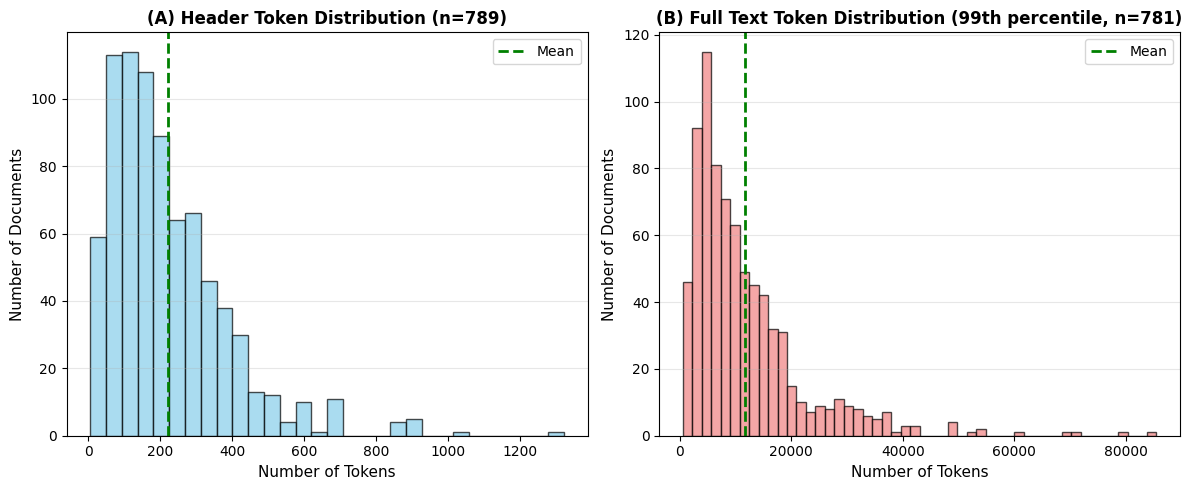

99th percentile: 85543 tokens
Excluded 8 extreme outliers


In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Header - (a)
plt.subplot(1, 2, 1)
plt.hist(header_tokens, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(header_tokens), color='green', linestyle='--', linewidth=2, label=f'Mean')
plt.xlabel('Number of Tokens', fontsize=11)
plt.ylabel('Number of Documents', fontsize=11)
plt.title(f'(A) Header Token Distribution (n=789)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Full Text - (b)
plt.subplot(1, 2, 2)
percentile_99 = np.percentile(policy_tokens, 99)
filtered_tokens = [t for t in policy_tokens if t <= percentile_99]
plt.hist(filtered_tokens, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(filtered_tokens), color='green', linestyle='--', linewidth=2, label=f'Mean')
plt.xlabel('Number of Tokens', fontsize=11)
plt.ylabel('Number of Documents', fontsize=11)
plt.title(f'(B) Full Text Token Distribution (99th percentile, n={len(filtered_tokens)})', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('token_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"99th percentile: {percentile_99:.0f} tokens")
print(f"Excluded {789-len(filtered_tokens)} extreme outliers")

In [ ]:
results = []

for case_id, case in cid.items():
    query = case["patient_info"]
    answer_md5 = case["expected_md5"]

    answer_file = None
    for fname, file_md5 in md5s.items():
        if file_md5 == answer_md5:
            answer_file = fname
            break
    
    candidates_header = retrieve_candidates(
        vecs=embedding_matrix_header,
        names=doc_names_header,
        query_text=query,
        embedder_id="all-MiniLM-L6-v2",
        k=len(doc_names_header)
    )

    candidates_policy = retrieve_candidates(
        vecs=embedding_matrix_policy,
        names=doc_names_policy,
        query_text=query,
        embedder_id="all-MiniLM-L6-v2",
        k=len(doc_names_policy)
    )

    rank_header = None
    for i, (fname, score, _) in enumerate(candidates_header, 1):
        if fname == answer_file:
            rank_header = i
            break

    rank_policy = None
    for i, (fname, score, _) in enumerate(candidates_policy, 1):
        if fname == answer_file:
            rank_policy = i
            break

    results.append({
        "case_id": case_id,
        "answer_file": answer_file,
        "rank_header": rank_header,
        "rank_policy": rank_policy
    })

    print(f"{case_id}: answer={answer_file}, header_rank={rank_header}, policy_rank={rank_policy}")

df = pd.DataFrame(results)
df.to_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank.csv", index=False)

Case14017: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=3, policy_rank=10
Case1778: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=24, policy_rank=6
Case4604: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=3, policy_rank=18
Case3422: answer=Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf, header_rank=44, policy_rank=11
Case10917: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=276, policy_rank=18
Case18821: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=11
Case13: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=2, policy_rank=16
Case8621: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=271, policy_rank=17
Case8051: answer=BCBS_FEP_204102 Whole Exome and.pdf, header_rank=1, policy_rank=4
Case13517: answer=United Healthcare_whole-exome-and-whole-genome-sequencing.pdf, header_rank=327,

In [8]:
mean_row = pd.DataFrame([{
    "case_id": "Mean_Rank",
    "answer_file": "",
    "rank_header": df["rank_header"].mean(),
    "rank_policy": df["rank_policy"].mean()
}])

df = pd.concat([df, mean_row], ignore_index=True)

df.to_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank.csv", index=False)

In [5]:
BASE_PATH = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final"

pairs = [
    # top1, 10retrieve
    ("top1_10retrieve_gpt_5_mini_gpt_5_update",          "gpt_5_mini", "gpt_5",      10, 1),
    ("top1_10retrieve_gpt_5_mini_gpt_5_mini_update",     "gpt_5_mini", "gpt_5_mini", 10, 1),
    
    # top1, 30retrieve
    ("top1_30retrieve_gpt_5_mini_gpt_5_update",          "gpt_5_mini", "gpt_5",      30, 1),
    ("top1_30retrieve_gpt_5_mini_gpt_5_mini_update",     "gpt_5_mini", "gpt_5_mini", 30, 1),
    
    # top3, 10retrieve
    ("top3_10retrieve_gpt_5_mini_gpt_5_update",          "gpt_5_mini", "gpt_5",      10, 3),
    ("top3_10retrieve_gpt_5_mini_gpt_5_mini_update",     "gpt_5_mini", "gpt_5_mini", 10, 3),
    
    # top3, 30retrieve
    ("top3_30retrieve_gpt_5_mini_gpt_5_update",          "gpt_5_mini", "gpt_5",      30, 3),
    ("top3_30retrieve_gpt_5_mini_gpt_5_mini_update",     "gpt_5_mini", "gpt_5_mini", 30, 3),
]

results = []

for folder, chunk_type, rerank_model, rcount, topk in pairs:
    file_path = os.path.join(BASE_PATH, folder, "retrieval", "gpt_5_mini", f"top{topk}", "matching_summary.csv")

    df = pd.read_csv(file_path)
    matched = df[(df["matched"] == 1) & (df["case_id"] != "Case17595")].copy()
    matched['rank_change'] = matched['orig_rank_cand'] - matched['llm_rank']

    matched_count = len(matched)
    match_rate = (matched_count / 105) * 100
    
    mrr_cosine = np.mean([1/rank for rank in matched['orig_rank_cand']])
    mrr_llm = np.mean([1/rank for rank in matched['llm_rank']])
    
    mean_row = pd.DataFrame([{
        "case_id": "Mean",
        "matched": "",
        "llm_rank": matched['llm_rank'].mean(),
        "orig_rank_cand": matched['orig_rank_cand'].mean(),
        "orig_rank_full": matched['orig_rank_full'].mean(),
        "doc_name": "",
        "rank_change": matched['rank_change'].mean()
    }])
    matched = pd.concat([matched, mean_row], ignore_index=True)

    results.append({
        "setting": folder,
        "chunk_type": chunk_type,
        "retrieve_count": rcount,
        "topk": topk,
        "matched_count": matched_count,
        "match_rate": match_rate,
        'mrr_cosine': mrr_cosine, 
        'mrr_llm': mrr_llm,
        'avg_orig_rank': matched['orig_rank_cand'].iloc[:-1].mean(),
        'avg_llm_rank': matched['llm_rank'].iloc[:-1].mean(),
        'avg_rank_change': matched['rank_change'].iloc[:-1].mean(),
        'improved_count': (matched['rank_change'].iloc[:-1] > 0).sum(),
        'same_count': (matched['rank_change'].iloc[:-1] == 0).sum(),
        'improved_percent': ((matched['rank_change'].iloc[:-1] > 0).sum() / matched_count) * 100 if matched_count > 0 else 0.0
    })

    output_path = os.path.join(BASE_PATH, folder, "retrieval", "gpt_5_mini", f"top{topk}", "rank_change_detail.csv")
    matched.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(BASE_PATH, "rank_change_summary_openai_small.csv"), index=False)

new_summary = summary_df.groupby(['chunk_type','topk', 'retrieve_count']).agg({
    'matched_count': 'mean',
    'match_rate': 'mean',
    'mrr_cosine': 'mean',
    'mrr_llm': 'mean',
    'avg_orig_rank': 'mean',
    'avg_llm_rank': 'mean',
    'avg_rank_change': 'mean',
    'improved_count': 'mean',
    'same_count': 'mean',
    'improved_percent': 'mean'
}).reset_index()

new_summary = new_summary.round(2)

print(new_summary)

Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_10retrieve_gpt_5_mini_gpt_5_update/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_10retrieve_gpt_5_mini_gpt_5_mini_update/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_30retrieve_gpt_5_mini_gpt_5_update/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_30retrieve_gpt_5_mini_gpt_5_mini_update/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3_10retrieve_gpt_5_mini_gpt_5_update/retrieval/gpt_5_mini/top3/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3_10retrieve_gpt_5_mini_gp

In [6]:
BASE_PATH = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final"

pairs = [
    # header: top1
    ("top1_10retrieve_gpt_5_mini_header_openai_small",  "header", 10, 1),
    ("top1_30retrieve_gpt_5_mini_header_openai_small",  "header", 30, 1),
    
    # header: top3
    ("top3_10retrieve_gpt_5_mini_header_openai_small",  "header", 10, 3),
    ("top3_30retrieve_gpt_5_mini_header_openai_small",  "header", 30, 3),
    
    # policy: top1
    ("top1_10retrieve_gpt_5_mini_policy_openai_small",  "policy", 10, 1),
    
    # policy: top3
    ("top3_10retrieve_gpt_5_mini_policy_openai_small",  "policy", 10, 3),
]


results = []

for folder, chunk_type, rcount, topk in pairs:
    file_path = os.path.join(BASE_PATH, folder, "retrieval", "gpt_5_mini", f"top{topk}", "matching_summary.csv")

    df = pd.read_csv(file_path)
    matched = df[(df["matched"] == 1) & (df["case_id"] != "Case17595")].copy()
    matched['rank_change'] = matched['orig_rank_cand'] - matched['llm_rank']

    matched_count = len(matched)
    match_rate = (matched_count / 105) * 100
    
    mrr_cosine = np.mean([1/rank for rank in matched['orig_rank_cand']])
    mrr_llm = np.mean([1/rank for rank in matched['llm_rank']])
    
    mean_row = pd.DataFrame([{
        "case_id": "Mean",
        "matched": "",
        "llm_rank": matched['llm_rank'].mean(),
        "orig_rank_cand": matched['orig_rank_cand'].mean(),
        "orig_rank_full": matched['orig_rank_full'].mean(),
        "doc_name": "",
        "rank_change": matched['rank_change'].mean()
    }])
    matched = pd.concat([matched, mean_row], ignore_index=True)

    results.append({
        "setting": folder,
        "chunk_type": chunk_type,
        "retrieve_count": rcount,
        "topk": topk,
        "matched_count": matched_count,
        "match_rate": match_rate,
        'mrr_cosine': mrr_cosine, 
        'mrr_llm': mrr_llm,
        'avg_orig_rank': matched['orig_rank_cand'].iloc[:-1].mean(),
        'avg_llm_rank': matched['llm_rank'].iloc[:-1].mean(),
        'avg_rank_change': matched['rank_change'].iloc[:-1].mean(),
        'improved_count': (matched['rank_change'].iloc[:-1] > 0).sum(),
        'same_count': (matched['rank_change'].iloc[:-1] == 0).sum(),
        'improved_percent': ((matched['rank_change'].iloc[:-1] > 0).sum() / matched_count) * 100 if matched_count > 0 else 0.0
    })

    output_path = os.path.join(BASE_PATH, folder, "retrieval", "gpt_5_mini", f"top{topk}", "rank_change_detail.csv")
    matched.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(BASE_PATH, "rank_change_summary_openai_small.csv"), index=False)

new_summary = summary_df.groupby(['chunk_type','topk', 'retrieve_count']).agg({
    'matched_count': 'mean',
    'match_rate': 'mean',
    'mrr_cosine': 'mean',
    'mrr_llm': 'mean',
    'avg_orig_rank': 'mean',
    'avg_llm_rank': 'mean',
    'avg_rank_change': 'mean',
    'improved_count': 'mean',
    'same_count': 'mean',
    'improved_percent': 'mean'
}).reset_index()

new_summary = new_summary.round(2)

print(new_summary)

Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_10retrieve_gpt_5_mini_header_openai_small/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_30retrieve_gpt_5_mini_header_openai_small/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3_10retrieve_gpt_5_mini_header_openai_small/retrieval/gpt_5_mini/top3/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3_30retrieve_gpt_5_mini_header_openai_small/retrieval/gpt_5_mini/top3/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top1_10retrieve_gpt_5_mini_policy_openai_small/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3

In [7]:
WHOLE_PATH = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/final/whole_policy"

pairs = [
    ("gpt_5_mini", 1),
    ("gpt_5_mini", 3),
]

results = []
for rerank_model, topk in pairs:
    file_path = os.path.join(WHOLE_PATH, "retrieval", rerank_model, f"top{topk}", "matching_summary.csv")
    
    df = pd.read_csv(file_path)
    matched = df[(df["matched"] == 1) & (df["case_id"] != "Case17595")].copy()
    
    if len(matched) > 0:
        matched['rank_change'] = matched['orig_rank_cand'] - matched['llm_rank']

        matched_count = len(matched)
        match_rate = (matched_count / 106) * 100

        mrr_cosine = np.mean([1/rank for rank in matched['orig_rank_cand']])
        mrr_llm = np.mean([1/rank for rank in matched['llm_rank']])

        mean_row = pd.DataFrame([{
            "case_id": "Mean",
            "matched": "",
            "llm_rank": matched['llm_rank'].mean(),
            "orig_rank_cand": matched['orig_rank_cand'].mean(),
            "orig_rank_full": matched['orig_rank_full'].mean(),
            "doc_name": "",
            "rank_change": matched['rank_change'].mean()
        }])
        matched = pd.concat([matched, mean_row], ignore_index=True)
        
        results.append({
            "rerank_model": rerank_model,
            "topk": topk,
            "matched_count": matched_count,
            "match_rate": match_rate,  
            'avg_orig_rank': matched['orig_rank_cand'].iloc[:-1].mean(),  
            'avg_llm_rank': matched['llm_rank'].iloc[:-1].mean(),
            'mrr_cosine': mrr_cosine, 
            'mrr_llm': mrr_llm,
            'avg_rank_change': matched['rank_change'].iloc[:-1].mean(),
            'improved_count': (matched['rank_change'].iloc[:-1] > 0).sum(),
            'same_count': (matched['rank_change'].iloc[:-1] == 0).sum(),
            'improved_percent': ((matched['rank_change'].iloc[:-1] > 0).sum() / matched_count) * 100 if matched_count > 0 else 0.0
        })
        
        output_path = os.path.join(WHOLE_PATH, "retrieval", rerank_model, f"top{topk}", "rank_change_detail.csv")
        matched.to_csv(output_path, index=False)
        print(f"Saved: {output_path}")

summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(WHOLE_PATH, "rank_change_summary.csv"), index=False)
print(f"\n요약 저장 완료: {os.path.join(WHOLE_PATH, 'rank_change_summary.csv')}")
print("\n=== 결과 요약 ===")
print(summary_df)

Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/final/whole_policy/retrieval/gpt_5_mini/top1/rank_change_detail.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/final/whole_policy/retrieval/gpt_5_mini/top3/rank_change_detail.csv

요약 저장 완료: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/final/whole_policy/rank_change_summary.csv

=== 결과 요약 ===
  rerank_model  topk  matched_count  match_rate  avg_orig_rank  avg_llm_rank  \
0   gpt_5_mini     1             51   48.113208       4.901961      1.000000   
1   gpt_5_mini     3             54   50.943396       4.814815      1.037037   

   mrr_cosine   mrr_llm  avg_rank_change  improved_count  same_count  \
0    0.305431  1.000000         3.901961              46           5   
1    0.305438  0.981481         3.777778              49           5   

   improved_percent  
0         90.196078  
1         90.740741  


In [ ]:
# 데이터 로드
df = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai.csv")
df = df[df['case_id'] != 'Mean_Rank']  # Mean 행 제외

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df['rank_header'], df['rank_policy'], alpha=0.6, s=100)

# 대각선 (rank_header == rank_policy)
max_rank = max(df['rank_header'].max(), df['rank_policy'].max())
plt.plot([1, max_rank], [1, max_rank], 'r--', alpha=0.5, label='Equal Rank')

plt.xlabel('Rank (Header)', fontsize=12)
plt.ylabel('Rank (Policy)', fontsize=12)
plt.title('Header vs Policy Ranking Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Top-10 영역 표시
plt.axvline(x=10, color='green', linestyle='--', alpha=0.3, label='Top-10')
plt.axhline(y=10, color='green', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('rank_comparison_scatter.png', dpi=300)
plt.show()

/tmp/ipykernel_40864/1617458668.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=['Header', 'Policy'], patch_artist=True)


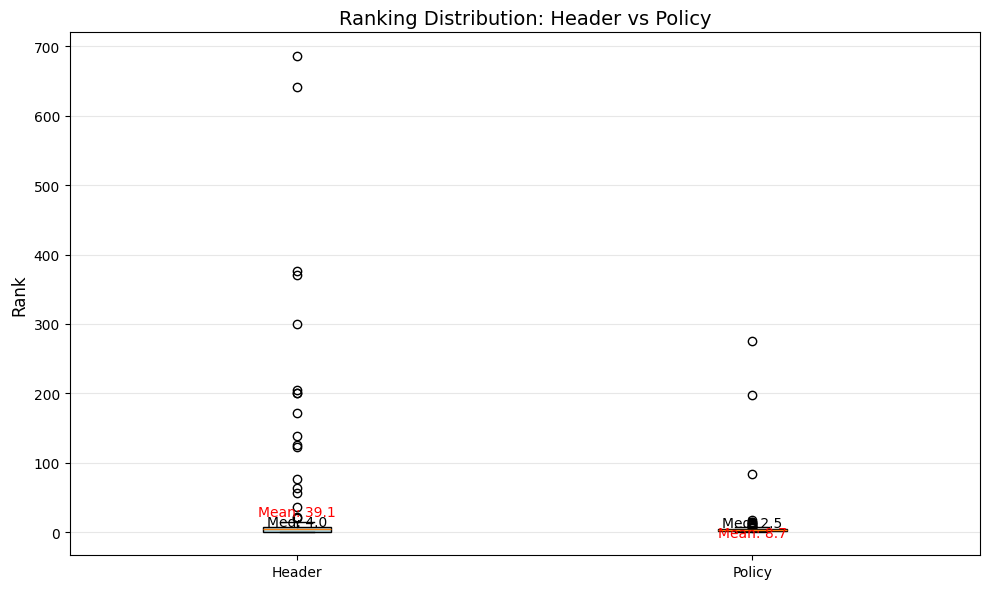

In [13]:
plt.figure(figsize=(10, 6))

data_to_plot = [df['rank_header'].dropna(), df['rank_policy'].dropna()]
box = plt.boxplot(data_to_plot, labels=['Header', 'Policy'], patch_artist=True)

# 색상
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Rank', fontsize=12)
plt.title('Ranking Distribution: Header vs Policy', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# 통계 표시
for i, data in enumerate(data_to_plot, 1):
    median = data.median()
    mean = data.mean()
    plt.text(i, median, f'Med: {median:.1f}', ha='center', va='bottom')
    plt.text(i, mean, f'Mean: {mean:.1f}', ha='center', va='top', color='red')

plt.tight_layout()
plt.savefig('rank_comparison_box.png', dpi=300)
plt.show()

In [ ]:
# 데이터 로드
df_openai = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai.csv")
df_openai = df_openai[df_openai['case_id'] != 'Mean_Rank']

df_sentence = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank.csv")
df_sentence = df_sentence[df_sentence['case_id'] != 'Mean_Rank']

# Figure 생성 (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === 전체 제목 ===
fig.suptitle('Initial Cosine Similarity based ranking results', 
             fontsize=16, fontweight='bold')

# === Row 1: OpenAI ===
# OpenAI - Header
axes[0, 0].hist(df_openai['rank_header'].dropna(), bins=20, alpha=0.7, 
                color='skyblue', edgecolor='black')
axes[0, 0].axvline(df_openai['rank_header'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_openai["rank_header"].mean():.1f}')
axes[0, 0].set_xlabel('Rank', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Summarized Ranking Distribution - OpenAI', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# OpenAI - Policy
axes[0, 1].hist(df_openai['rank_policy'].dropna(), bins=20, alpha=0.7, 
                color='lightcoral', edgecolor='black')
axes[0, 1].axvline(df_openai['rank_policy'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_openai["rank_policy"].mean():.1f}')
axes[0, 1].set_xlabel('Rank', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Whole Policy Ranking Distribution - OpenAI', fontsize=13)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# === Row 2: SentenceTransformer ===
# SentenceTransformer - Header
axes[1, 0].hist(df_sentence['rank_header'].dropna(), bins=20, alpha=0.7, 
                color='skyblue', edgecolor='black')
axes[1, 0].axvline(df_sentence['rank_header'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_sentence["rank_header"].mean():.1f}')
axes[1, 0].set_xlabel('Rank', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Summarized Ranking Distribution - SentenceTransformer', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# SentenceTransformer - Policy
axes[1, 1].hist(df_sentence['rank_policy'].dropna(), bins=20, alpha=0.7, 
                color='lightcoral', edgecolor='black')
axes[1, 1].axvline(df_sentence['rank_policy'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_sentence["rank_policy"].mean():.1f}')
axes[1, 1].set_xlabel('Rank', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Whole Policy Ranking Distribution - SentenceTransformer', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# === PDF로 저장 (dpi=300) ===
plt.savefig('s_figure1.pdf', dpi=300, bbox_inches='tight')

plt.show()

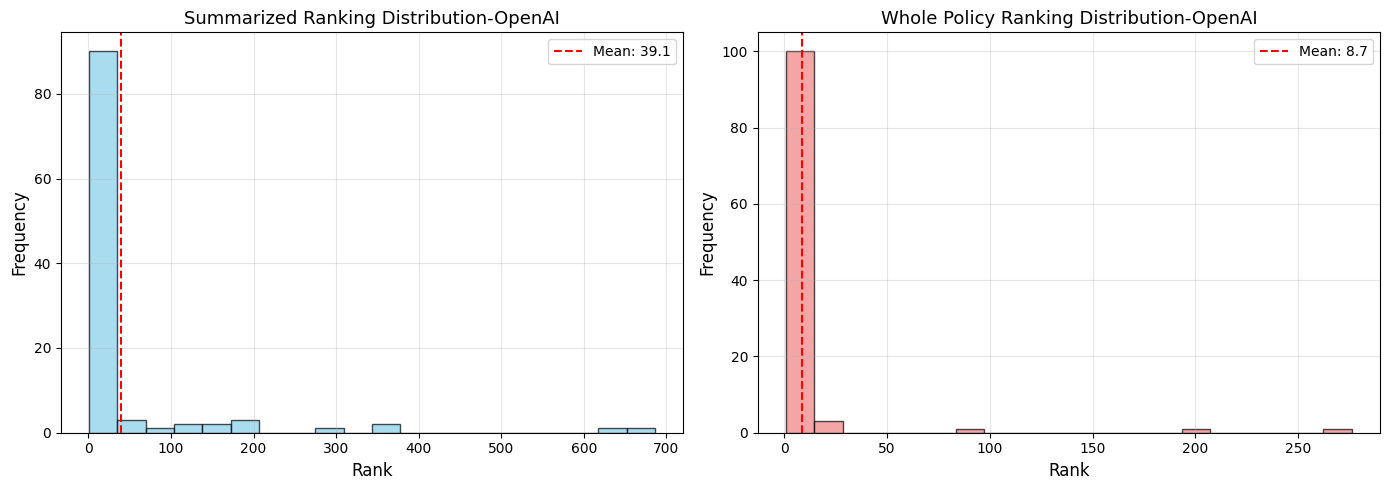

In [2]:
df = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai.csv")
df = df[df['case_id'] != 'Mean_Rank']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Header
axes[0].hist(df['rank_header'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(df['rank_header'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_header"].mean():.1f}')
axes[0].set_xlabel('Rank', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Summarized Ranking Distribution-OpenAI', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Policy
axes[1].hist(df['rank_policy'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(df['rank_policy'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_policy"].mean():.1f}')
axes[1].set_xlabel('Rank', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Whole Policy Ranking Distribution-OpenAI', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rank_distribution_hist.png', dpi=300)
plt.show()

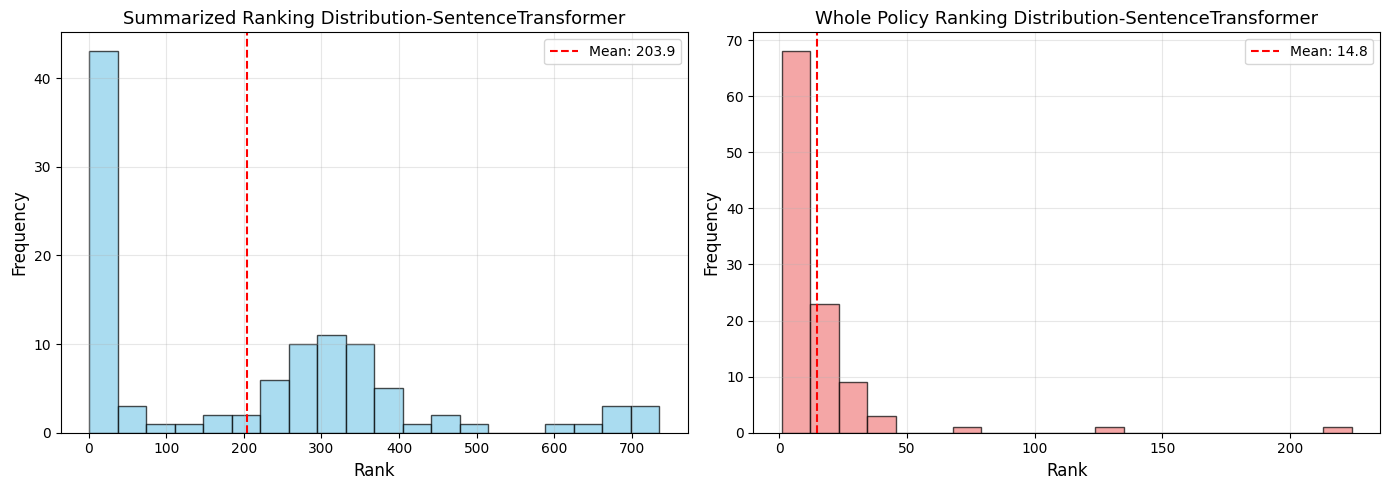

In [2]:
df = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank.csv")
df = df[df['case_id'] != 'Mean_Rank'] 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Header
axes[0].hist(df['rank_header'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(df['rank_header'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_header"].mean():.1f}')
axes[0].set_xlabel('Rank', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Summarized Ranking Distribution-SentenceTransformer', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Policy
axes[1].hist(df['rank_policy'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(df['rank_policy'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_policy"].mean():.1f}')
axes[1].set_xlabel('Rank', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Whole Policy Ranking Distribution-SentenceTransformer', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rank_distribution_hist_sentence.png', dpi=300)
plt.show()


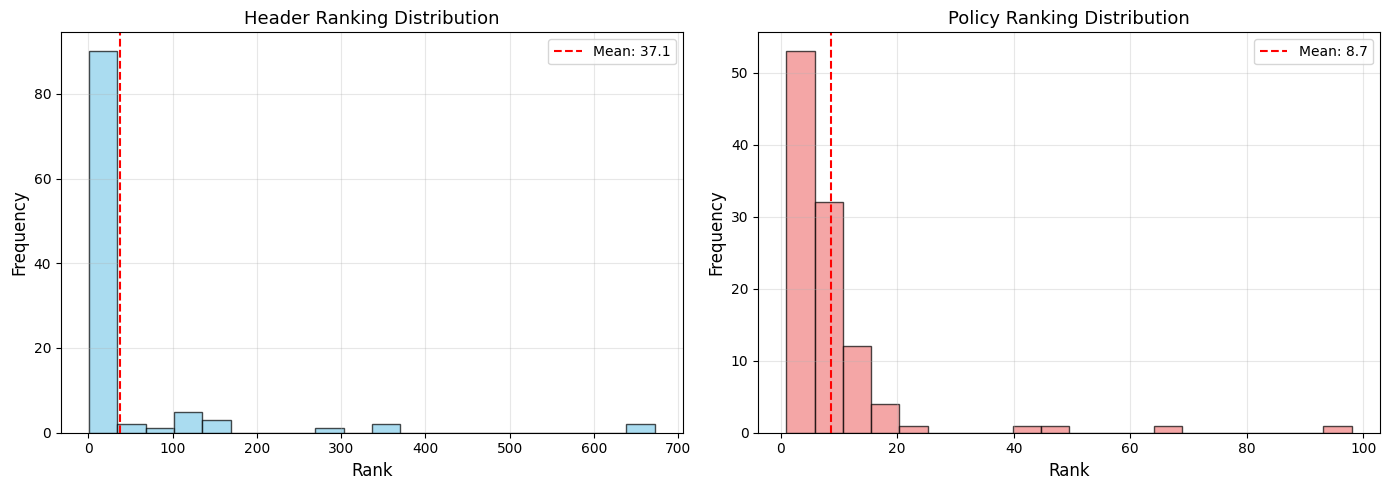

: 

In [ ]:
df = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai_large.csv")
df = df[df['case_id'] != 'Mean_Rank'] 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Header
axes[0].hist(df['rank_header'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(df['rank_header'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_header"].mean():.1f}')
axes[0].set_xlabel('Rank', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Header Ranking Distribution', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Policy
axes[1].hist(df['rank_policy'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(df['rank_policy'].mean(), color='red', linestyle='--', label=f'Mean: {df["rank_policy"].mean():.1f}')
axes[1].set_xlabel('Rank', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Policy Ranking Distribution', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rank_distribution_hist.png', dpi=300)
plt.show()